# Image Classification
 Rock-Paper-Scissors

## Importing Module

In [ ]:
import os
import random
import zipfile
import urllib.request
import tensorflow as tf
import matplotlib.image as mpimg


from pathlib import Path
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

print(f'Tensorflow Version : {tf.__version__}')

Tensorflow Version : 2.8.2


## Problem

- Build a CNN based classifier for Rock-Paper-Scissors dataset.
- Your input layer should accept `150x150` with 3 bytes color as the input shape.
- This is unlabeled data, use ImageDataGenerator to automatically label it.
- Don't use lambda layers in your model.
- The dataset used in this problem is created by Laurence Moroney (laurencemoroney.com).
- Desired accuracy AND validation_accuracy > `83%`

### Preparing data

In [ ]:
data_url = 'https://github.com/dicodingacademy/assets/releases/download/release-rps/rps.zip'

name_file = 'rps.zip'
target_path = 'data/'

if os.path.isfile(name_file):
  print(f'{name_file} Already exist')
else:
  # Download data
  urllib.request.urlretrieve(data_url, name_file)

  # Extract file
  zip_ref = zipfile.ZipFile(name_file, 'r')
  zip_ref.extractall(target_path)
  zip_ref.close()
  print(f'{name_file} Download and Extract finished')

rps.zip Already exist


Check total file

In [ ]:
base_dir = Path('./data/rps/')

list_dir = os.listdir(base_dir)
image_count = len(list(base_dir.glob("*/*")))

print(f'Total Image : {image_count}\n')

for dir in list_dir:
  image_count_dir = len(list(base_dir.glob(f'{dir}/*')))
  print(f'{dir} : {image_count_dir}')

Total Image : 2520

rock : 840
scissors : 840
paper : 840


### Explore data

In [ ]:
def load_random_imgs_from_folder(folder,label):
  plt.figure(figsize=(15,15))
  for i in range(3):
    file = random.choice(os.listdir(folder))
    image_path = os.path.join(folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,3,i+1)
    ax.title.set_text(label)
    plt.xlabel(f'Name: {file}')
    plt.imshow(img)

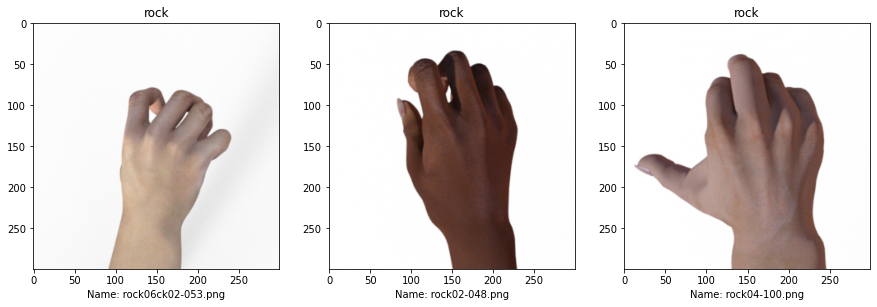

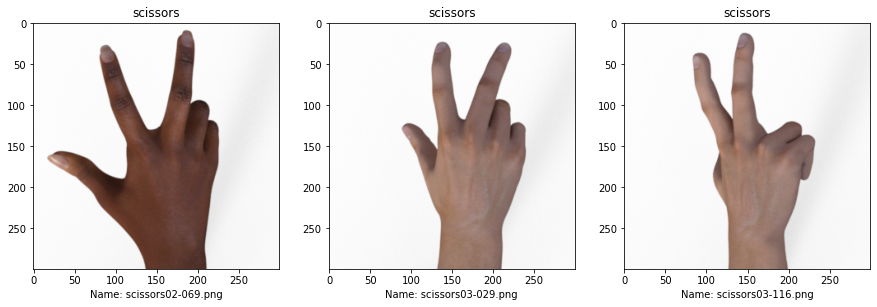

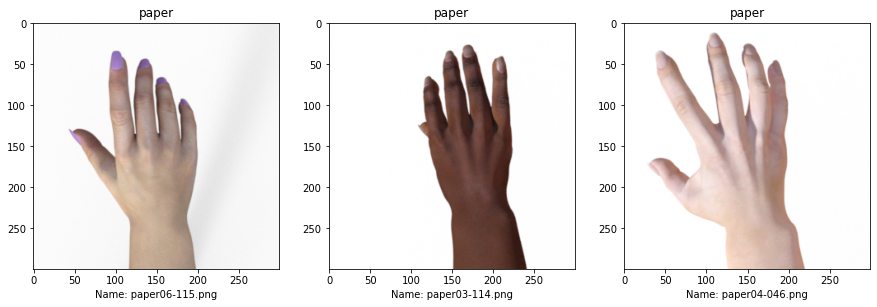

In [ ]:
for dir in list_dir:
  image_dir = os.path.join(base_dir, dir)
  load_random_imgs_from_folder(image_dir, dir)

### Preparing Train Model

Set Paramters

In [ ]:
IMG_SIZE = (150,150)
BATCH_SIZE = 64

#### Image Augmentation
Using [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   shear_range = 0.2, 
                                   horizontal_flip=True, 
                                   fill_mode = 'wrap',
                                   validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(base_dir,  
                                                    target_size=IMG_SIZE,  
                                                    shuffle = True,
                                                    subset='training',
                                                    batch_size = BATCH_SIZE,
                                                    class_mode='categorical')


test_datagen = ImageDataGenerator(rescale=1./255,
                                  validation_split = 0.2)

validation_generator = test_datagen.flow_from_directory(base_dir, 
                                                        target_size=IMG_SIZE,  
                                                        subset='validation', 
                                                        batch_size = BATCH_SIZE//2,
                                                        class_mode='categorical')

Found 2016 images belonging to 3 classes.
Found 504 images belonging to 3 classes.


#### Build Model

In [ ]:
def build_model():
  """
  Create a model sequential with convolutional layers

  Returns:
      model (tf.keras Model): the Image classifier model
  """

  # Define Params
  lr = 1e-3
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.CategoricalCrossentropy()

  # Define Activation Function
  relu = tf.nn.relu
  softmax = tf.nn.softmax

  # Define model sequential
  model = tf.keras.Sequential()

  # Define convolutional layers
  model.add(tf.keras.layers.Conv2D(16, 3, padding='same', activation=relu, input_shape=IMG_SIZE + (3,)))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(32, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))
  model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation=relu))
  model.add(tf.keras.layers.MaxPooling2D(2, 2))

  # Define fully connected layers
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.7))
  model.add(tf.keras.layers.Dense(512, activation=relu))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.Dense(3, activation=softmax))

  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['accuracy'])

  # Check Summary Model
  model.summary()

  print('\nModel Successfully Create')
  
  return model

In [ ]:
model = build_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 18, 18, 64)      

#### Define Callbacks

In [ ]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="val_accuracy",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                  patience=4, 
                                                  mode ="max", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

### Train Model

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,
      epochs=20,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
      callbacks=[model_checkpoint, early_stopping])

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 1.0990 - accuracy: 0.3571
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to model.h5
32/32 [==============================] - 36s 537ms/step - loss: 1.0990 - accuracy: 0.3571 - val_loss: 1.0981 - val_accuracy: 0.3333
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.8371 - accuracy: 0.5918
Epoch 2: val_accuracy improved from 0.33333 to 0.65278, saving model to model.h5
32/32 [==============================] - 17s 530ms/step - loss: 0.8371 - accuracy: 0.5918 - val_loss: 0.6413 - val_accuracy: 0.6528
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.2963 - accuracy: 0.8879
Epoch 3: val_accuracy improved from 0.65278 to 0.84921, saving model to model.h5
32/32 [==============================] - 17s 530ms/step - loss: 0.2963 - accuracy: 0.8879 - val_loss: 0.2928 - val_accuracy: 0.8492
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.1493 - accur

### Visualization result

In [ ]:
def visualize_result(history):
  '''Function for Visual result'''
  
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='best')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='best')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.show()

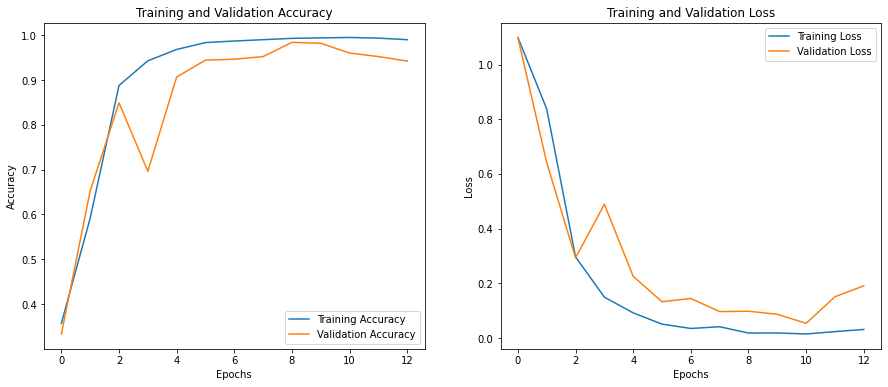

In [ ]:
visualize_result(history)

### Download Model

In [ ]:
from google.colab import files
files.download('model.h5') 